# MLJ glass transition curves

Take a handful of pressure, find the temperature where D ~ 1.0, then quench the system to kT=0

## Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm, colors
import glob

from numba import njit, vectorize, float32

from typing import Callable, Optional, Union

import hoomd
import gsd.hoomd

import sys
import time
import pickle
import gc

import signac

In [3]:
from monk import nb, prep, pair, render, grid
import freud

In [16]:
project = signac.init_project('mlj-glass-transition-curves')

In [17]:
project.doc["phi_init"] = 0.8
project.doc["kT_init"] = 2.0
project.doc["target_D"] = 0.1
project.doc["D_probe_period"] = 10.0
project.doc["quench_rate"] = 1e-2

{}

In [15]:
gridspec = {
    'delta': [0.0, 0.2, 0.6, 0.8],
    'p': [0.2, 0.5, 1.0, 2.0, 5.0, 10.0, 20.0, 50.0, 100.0]
}

N = 2**15

sps = grid(gridspec)
for i, sp in enumerate(sps):
    sp.update({"N": N, "seed": i})
    print(sp)

{'delta': 0.0, 'p': 0.2, 'N': 32768, 'seed': 0}
{'delta': 0.0, 'p': 0.5, 'N': 32768, 'seed': 1}
{'delta': 0.0, 'p': 1.0, 'N': 32768, 'seed': 2}
{'delta': 0.0, 'p': 2.0, 'N': 32768, 'seed': 3}
{'delta': 0.0, 'p': 5.0, 'N': 32768, 'seed': 4}
{'delta': 0.0, 'p': 10.0, 'N': 32768, 'seed': 5}
{'delta': 0.0, 'p': 20.0, 'N': 32768, 'seed': 6}
{'delta': 0.2, 'p': 0.2, 'N': 32768, 'seed': 7}
{'delta': 0.2, 'p': 0.5, 'N': 32768, 'seed': 8}
{'delta': 0.2, 'p': 1.0, 'N': 32768, 'seed': 9}
{'delta': 0.2, 'p': 2.0, 'N': 32768, 'seed': 10}
{'delta': 0.2, 'p': 5.0, 'N': 32768, 'seed': 11}
{'delta': 0.2, 'p': 10.0, 'N': 32768, 'seed': 12}
{'delta': 0.2, 'p': 20.0, 'N': 32768, 'seed': 13}
{'delta': 0.6, 'p': 0.2, 'N': 32768, 'seed': 14}
{'delta': 0.6, 'p': 0.5, 'N': 32768, 'seed': 15}
{'delta': 0.6, 'p': 1.0, 'N': 32768, 'seed': 16}
{'delta': 0.6, 'p': 2.0, 'N': 32768, 'seed': 17}
{'delta': 0.6, 'p': 5.0, 'N': 32768, 'seed': 18}
{'delta': 0.6, 'p': 10.0, 'N': 32768, 'seed': 19}
{'delta': 0.6, 'p': 20.0,

render.render_sphere_frame(sim.state.get_snapshot())

In [214]:
def reach_target_D(sim: hoomd.Simulation, npt: hoomd.md.methods.NPT, D: float) -> float:
    npt.

def run_quench(sim: hoomd.Simulation, job: signac.Project.Job):
    temp = 1.0
    end_temp = 0.01
    speed = 1e-3
    steps = int(1_000*(temp-end_temp)/speed)

    D = job.doc['target_D']

    delta = job.sp['delta']
    p = job.sp['p']
    initial_equil = job.doc["initial_equil"]
    dt = job.doc["dt"]

    equil_steps = int(initial_equil/dt)

    integrator = hoomd.md.Integrator(dt=dt)
    tree = hoomd.md.nlist.Tree(0.3)
    mlj = pair.KA_ModLJ(tree, delta)
    variant = hoomd.variant.Ramp(temp, end_temp, sim.timestep + equil_steps, steps)
    npt = hoomd.md.methods.NPT(hoomd.filter.All(), variant, 0.1, p, 0.4, "xyz", gamma=0.1)
    npt.kT = 5.0
    integrator.forces = [mlj]
    integrator.methods = [npt]

    sim.operations.integrator = integrator

    sim.state.thermalize_particle_momenta(hoomd.filter.All(), 1.5)

    sim.run(40_000)
    # nvt.thermalize_thermostat_dof()

    log = hoomd.logging.Logger(categories=["scalar"])
    analyzer = hoomd.md.compute.ThermodynamicQuantities(filter=hoomd.filter.All())
    sim.operations.computes.append(analyzer)
    log.add(analyzer)

    file = open(f'_log_quench-test_rate-{speed}.log', mode='w', newline='\n')
    table = hoomd.write.Table(hoomd.trigger.Periodic(1_000), output=file, logger=log)

    writer = hoomd.write.GSD(hoomd.trigger.Periodic(1_000), f"_quench-test_rate-{speed}.gsd", mode="wb")
    sim.operations.writers.clear()
    sim.operations.writers.append(writer)
    sim.operations.writers.append(table)

def generate_glass_transition_curve(job: signac.Project.Job):
    N = job.sp['N']
    seed = job.sp['seed']

    phi_init = job.doc['phi_init']

    sim = prep.quick_sim(N, phi_init, hoomd.device.GPU(), ratios=[80, 20], diams=[1.0, 0.88], seed=seed)

    run_quench(sim, job)

In [215]:
sim.timestep

0

In [216]:
sim.run(steps + 40_000)

render.render_sphere_frame(sim.state.get_snapshot())

In [162]:
gc.collect()

682

In [ ]:
quench_params = {
    0.0: {
        1.5
    }
}

## Potential form

What does this look like again for different $\Delta$ values?

In [100]:
def mlj(r, delta):
    sigma = 1 - delta*2**(-1/6)
    term = sigma/(r - delta)
    return 4 * (term**12 - term**6)

/tmp/ipykernel_9504/3357127588.py:3: RuntimeWarning: divide by zero encountered in true_divide
  term = sigma/(r - delta)
/tmp/ipykernel_9504/3357127588.py:4: RuntimeWarning: invalid value encountered in subtract
  return 4 * (term**12 - term**6)


Text(0.5, 0, '$r$')

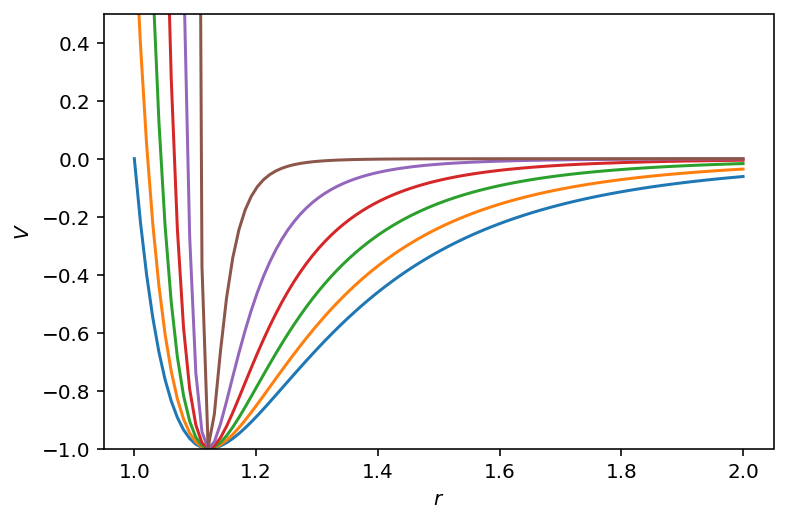

In [105]:
x = np.linspace(1.0, 2.0, 100)

for d in np.linspace(0.0, 1.0, 6):
    plt.plot(x, mlj(x, d))

plt.ylim(-1, 0.5)
plt.ylabel(r"$V$")
plt.xlabel(r"$r$")

## Inspect logs

In [244]:
logs = glob.glob("_log_*.log")

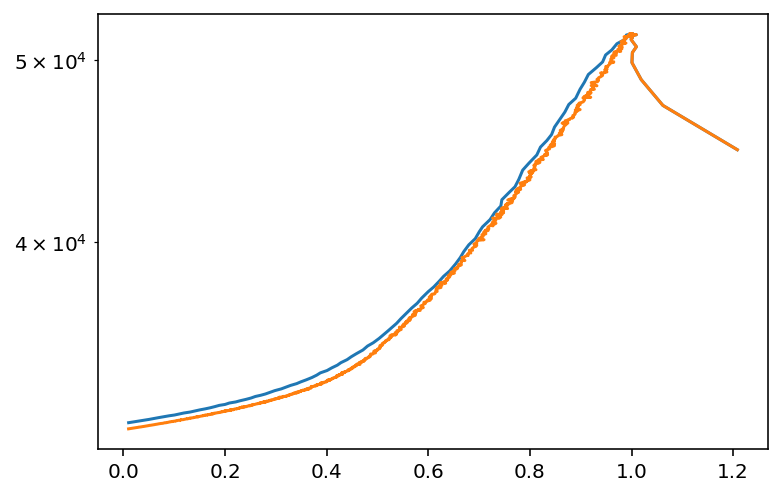

In [245]:
label = 2

for log_file in logs:
    df = pd.read_csv(log_file, sep='\s+', header=0)
    l, = plt.plot(df["md.compute.ThermodynamicQuantities.kinetic_temperature"], df["md.compute.ThermodynamicQuantities.volume"])
plt.yscale('log')

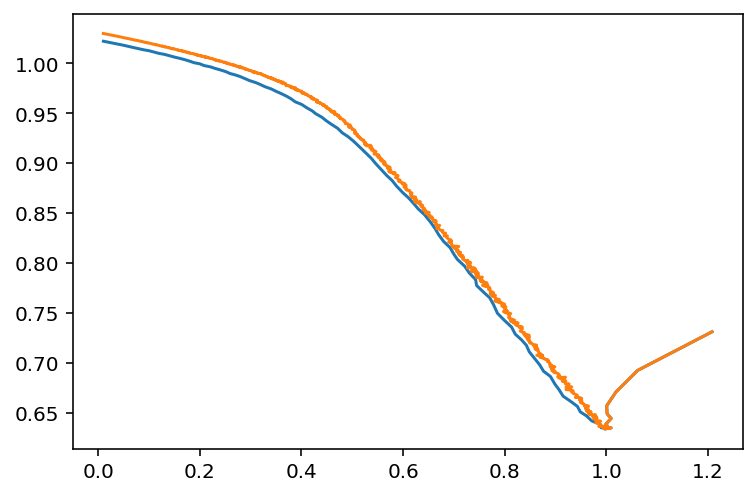

In [246]:
label = 2

for log_file in logs:
    df = pd.read_csv(log_file, sep='\s+', header=0)
    l, = plt.plot(df["md.compute.ThermodynamicQuantities.kinetic_temperature"], N/df["md.compute.ThermodynamicQuantities.volume"])

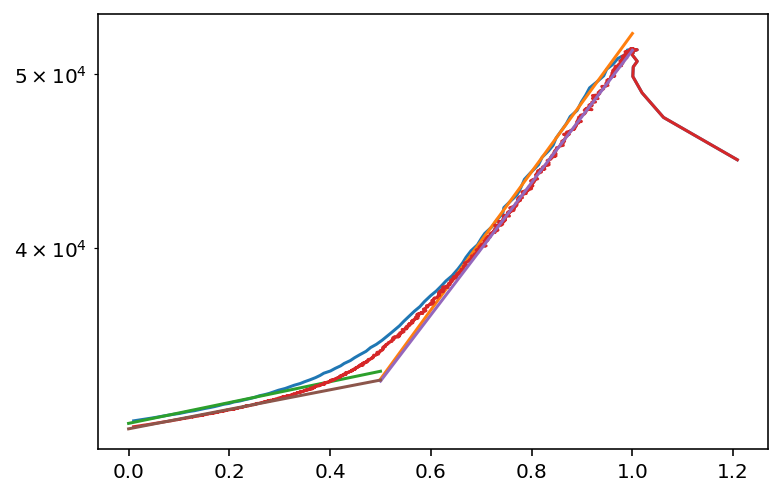

In [250]:
for log_file in logs:
    df = pd.read_csv(log_file, sep='\s+', header=0)
    x = df["md.compute.ThermodynamicQuantities.kinetic_temperature"]
    y = df["md.compute.ThermodynamicQuantities.volume"]
    plt.plot(x, y)

    cond = np.logical_and(x < 0.95, x > 0.7)
    fit = np.polyfit(x[cond], np.log(y[cond]), 1)
    xd = np.linspace(.5, 1.0, 100)
    plt.plot(xd, np.exp(xd*fit[0] + fit[1]))


    cond = x < 0.3
    fit = np.polyfit(x[cond], np.log(y[cond]), 1)
    xd = np.linspace(0.0, 0.5, 100)
    plt.plot(xd, np.exp(xd*fit[0] + fit[1]))

plt.yscale('log')

In [237]:
fit

array([ 0.12525339, 10.36495359])